# MODELO PREDICTIVO - LIGHTGBM PARA CLASIFICACIÓN

Con este modelo intentaremos clasificar en qué rango de ingresos se encuentra un mujer jefa de hogar monomarental partiendo de un conjunto de features determinantes. Luego, con el resultado podremos comparar cómo el cambio a nivel de género, entre otros, afectaría el outcome del mismo.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

df = pd.read_csv('new_df.csv')

<Figure size 576x576 with 0 Axes>

In [3]:
# Feautures
X = df.drop('rango_sueldos', axis=1).to_numpy()
y = df['rango_sueldos']

print('X shape', X.shape, '\nY shape', y.shape)

X shape (22640, 24) 
Y shape (22640,)


In [4]:
# Definimos los feautures de test y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

print('X shape', X.shape, '\nY shape', y.shape)

X shape (22640, 24) 
Y shape (22640,)


### Creamos un pipeline de clasificación con el fin de encontrar los mejores parámetros y ver cómo se ajusta el modelo a los datos.

In [5]:
# Creamos el pipeline de ejecución
one_hot = OneHotEncoder(handle_unknown='ignore')
normalizer = Normalizer()

pipe = Pipeline(
    steps=[('encoder', one_hot),
           ('normalizer', normalizer),
           ('lightgbm', LGBMClassifier())
           ])

In [6]:
#Conocemos los hyparámetros que podemos personalizar
for key,value in LGBMClassifier().get_params().items():
    print(key,': ', value)

boosting_type :  gbdt
class_weight :  None
colsample_bytree :  1.0
importance_type :  split
learning_rate :  0.1
max_depth :  -1
min_child_samples :  20
min_child_weight :  0.001
min_split_gain :  0.0
n_estimators :  100
n_jobs :  -1
num_leaves :  31
objective :  None
random_state :  None
reg_alpha :  0.0
reg_lambda :  0.0
silent :  warn
subsample :  1.0
subsample_for_bin :  200000
subsample_freq :  0


In [7]:
# Definimos los parámetros para el cross validation
param_grid = {
    'lightgbm__num_leaves':[31, 62, 70,100],
    'lightgbm__max_depth':[-1, 5, 10],
    'lightgbm__max_boosting_type':['gbdt', 'dart', 'goss', 'rf'],
    'lightgbm__n_estimators':[100,200,500],
    'lightgbm__objective': ['regression', 'multiclass', 'lambdarank']
}

In [8]:
# Creamos y determinamos el score del modelo
search = RandomizedSearchCV(pipe,
                            param_grid,
                            n_jobs=-1,
                            scoring='accuracy',
                            cv=5,
                            n_iter=5)

search.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: max_boosting_type


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('encoder',
                                              OneHotEncoder(handle_unknown='ignore')),
                                             ('normalizer', Normalizer()),
                                             ('lightgbm', LGBMClassifier())]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'lightgbm__max_boosting_type': ['gbdt',
                                                                        'dart',
                                                                        'goss',
                                                                        'rf'],
                                        'lightgbm__max_depth': [-1, 5, 10],
                                        'lightgbm__n_estimators': [100, 200,
                                                                   500],
                                        'lightgbm__num_leaves': [31, 62, 70,
               

In [9]:
print(search.score(X_train, y_train))
print(search.score(X_test, y_test))

0.5813351842503786
0.48542402826855124


In [10]:
search.best_params_

{'lightgbm__objective': 'lambdarank',
 'lightgbm__num_leaves': 100,
 'lightgbm__n_estimators': 200,
 'lightgbm__max_depth': 5,
 'lightgbm__max_boosting_type': 'gbdt'}

<AxesSubplot:>

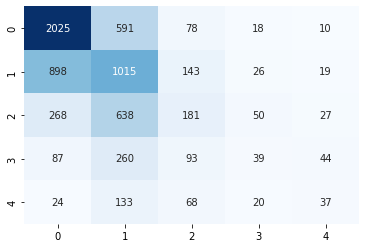

In [11]:
# Predicción
prediction = search.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test,prediction)

sns.heatmap(cm,annot=True,cmap='Blues',cbar=False,fmt='.0f')

La matriz presenta una distribución de aciertos no muy efectiva, lo que quiere decir que el modelo no está encontrando el mejor camino parala predicción. Lo mismo se encuentra en el reporte de clasificación a continuación.

In [12]:
#Reporte de clasificación
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.61      0.74      0.67      2722
           1       0.38      0.48      0.43      2101
           2       0.32      0.16      0.21      1164
           3       0.25      0.07      0.12       523
           4       0.27      0.13      0.18       282

    accuracy                           0.49      6792
   macro avg       0.37      0.32      0.32      6792
weighted avg       0.45      0.49      0.45      6792



# Consideraciones

Los valores del siguiente modelo demuestran que el dataset o el modelo elegido puede no ser el ideal para manejar este tipo de datos y realizar las predicciones estimadas. De todas formas  nos ofrece una perspectiva general de cómo se compartan los mismos con el modelo.

En la siguiente notebook, determinaremos la  efectividad de un pipeline más adecuado para manjear los atributos categóricos y numéricos, buscando una robustez mayor del modelo. Llevaremos los datos a valores nuéricos en su transformación y con el apoyo de una regresión analizaremos los resultados.